# Oscilloskope USBTCM utility

In [91]:
import matplotlib.pyplot as plt
import sys
import os
import time
import h5py
import numpy as np

class UsbTmcDriver:

    def __init__(self, device):
        self.device = device
        self.FILE = os.open(device, os.O_RDWR)
 
    def write(self, command):
        os.write(self.FILE, command);
 
    def read(self, length = 500):
        return os.read(self.FILE, length)
 
    def getName(self):
        self.write("*IDN?")
        return self.read(300)
 
    def sendReset(self):
        self.write("*RST")  # Be carefull, this real resets an oscilloscope

# Looking for USBTMC device
def getDeviceList(): 
    dirList=os.listdir("/dev")
    result=list()

    for fname in dirList:
        if(fname.startswith("usbtmc")):
            result.append("/dev/" + fname)

    return result

# looking for oscilloscope
devices =  getDeviceList()
# initiate oscilloscope
osc = UsbTmcDriver(devices[0])


## Read number of waveforms and wtite it to a file

<IPython.core.display.Javascript object>


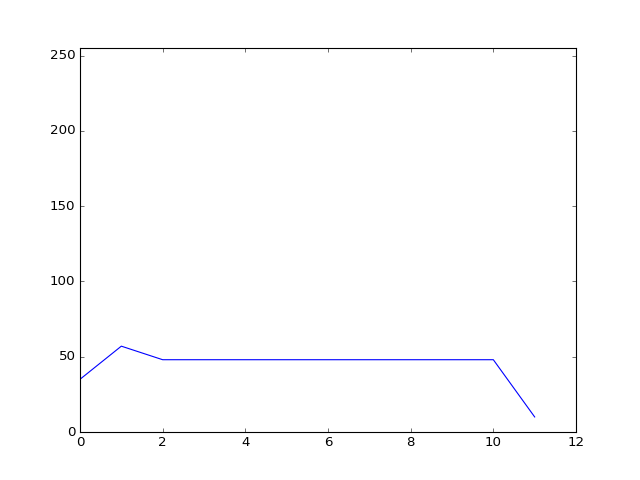

XINC: 5e-10
YINC: 0.0008
IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0

IDLE,0



In [102]:
runs = 100

%matplotlib notebook
fig,ax = plt.subplots(1,1)

osc.write(':WAV:XINC?')
xinc = float(osc.read(100))
print 'XINC:', xinc
osc.write(':WAV:YINC?')
yinc = float(osc.read(100))
print 'YINC:', yinc

osc.write(':WAV:SOUR CHAN1')
osc.write(':WAV:MODE RAW')
osc.write(':WAV:FORM BYTE')
osc.write(':WAV:POIN 1000')

with h5py.File('data.h5', 'w') as hf:
    hf.create_dataset('XINC', data=(xinc))
    hf.create_dataset('YINC', data=(yinc))
    #hf.create_dataset('YINC', bytearray(yinc))
    for n in range(runs):
        #osc.write(':RUN')
        # waiting for SINGLE trigger
        osc.write(':SING')
        osc.write(':TRIG:STAT?')
        while (osc.read(4) != 'STOP'):
            osc.write(':TRIG:STAT?')
        #time.sleep(0.4)

        osc.write(':WAV:RES')
        osc.write(':WAV:BEG')
        #time.sleep(0.1)

        osc.write(':WAV:STAT?')
        print osc.read(100)
        
        osc.write(':WAV:DATA?')
        #for n in range(3):
        wave = bytearray(osc.read(500))
        #print wave[:30]
        #print ''.join('{:02x}'.format(x) for x in wave[:100])
        #wave2 = bytearray(osc.read(700))
        #wave = np.concatenate((wave1[11:],wave2[:(700-489)]))
        osc.write(':WAV:END')
        hf.create_dataset(str(n), data=wave)
        fig.clf()
        plt.ylim(0, 255)
        plt.plot(wave)
        fig.canvas.draw()

 

## Read waveforms from the file

XINC: 5e-05    YINC: 2e-05
66 151 78696
65 152 75717
64 151 78575
65 152 79045
67 153 79205
65 152 78600
65 152 75172
67 151 78212
68 154 79543
66 152 79290


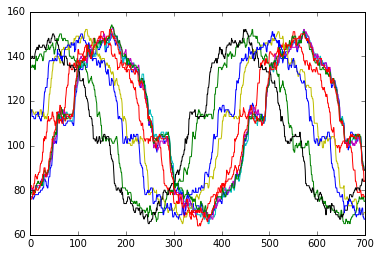

In [93]:
%matplotlib inline 

with h5py.File('data.h5','r') as hf:
    #print('List of arrays in this file: \n', hf.keys())
    print 'XINC:', np.array(hf.get('XINC')), '   YINC:', np.array(hf.get('YINC'))
    for n in range(10):
        data = hf.get(str(n))
        np_data = np.array(data)
        plt.plot(np_data)
        #print np_data
        maximum = 0
        minimum = 255
        suma = 0
        for i in range(700):
            if np_data[i] > maximum:
                maximum = np_data[i]
            if np_data[i] < minimum:
                minimum = np_data[i]
            suma = suma + np_data[i]
        print minimum, maximum, suma


## Capture waveforms and plot it

<IPython.core.display.Javascript object>


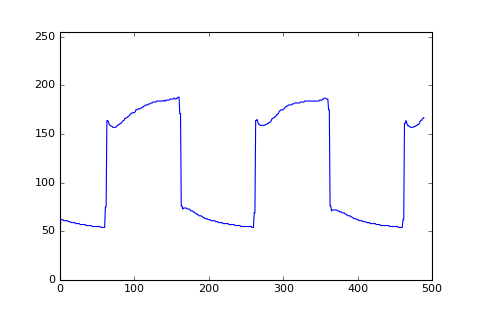

In [98]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)

# looking for oscilloscope
devices =  getDeviceList()
# initiate oscilloscope
osc = UsbTmcDriver(devices[0])

df = pd.Series(0) # Create a new dataframe

for n in range(10):
    # waiting for SINGLE trigger
    osc.write(':SINGLE')
    osc.write(':TRIG:STAT?')
    while (osc.read(4) != 'STOP'):
        osc.write(':TRIG:STAT?')

    #osc.write(':STOP')
    osc.write(':WAV:SOUR CHAN1')
    osc.write(':WAV:MODE NORM')
    osc.write(':WAV:FORM BYTE')
    osc.write(':WAV:DATA?')

    #wave = map(float, osc.read(100).split(','))
    wave = bytearray(osc.read(1400))

    fig.clf()
    plt.ylim(0, 255)
    plt.plot(wave[10:])
    fig.canvas.draw()
    time.sleep(0.1)
